In [1]:
# Import required libraries
import pandas as pd
import pymongo
import sshtunnel
import os
from dotenv import load_dotenv


In [49]:
load_dotenv(".env")  # Load environment variables from .env file
MONGO_DB = "Windows-DESKTOP-FP721C3"
MONGO_COLLECTION = "COM3"
# SSH connection parameters
SSH_HOST = os.getenv('SSH_HOST', 'your_ssh_host')
SSH_PORT = int(os.getenv('SSH_PORT', 22))
SSH_USERNAME = os.getenv('SSH_USERNAME', 'your_ssh_username')
SSH_PASSWORD = os.getenv('SSH_PASSWORD', None)

# MongoDB connection parameters
MONGO_HOST = os.getenv('MONGO_HOST', 'localhost')
MONGO_PORT = int(os.getenv('MONGO_PORT', 27017))
LOCAL_MONGO_PORT = int(os.getenv('LOCAL_MONGO_PORT', 37017))


In [50]:
# Function to connect to MongoDB via SSH tunnel and load data into pandas DataFrame
def load_mongodb_data_via_ssh():
    """
    Connect to MongoDB through an SSH tunnel and load data from a collection into a pandas DataFrame.

    Returns:
        pandas.DataFrame: DataFrame containing the data from MongoDB collection
    """
    # Create SSH tunnel
    print("Establishing SSH connection...")

    # Configure SSH tunnel parameters
    ssh_tunnel_args = {
        'ssh_address_or_host': (SSH_HOST, SSH_PORT),
        'ssh_username': SSH_USERNAME,
        'ssh_password': SSH_PASSWORD,
        'remote_bind_address': (MONGO_HOST, MONGO_PORT),
        'local_bind_address': ('localhost', LOCAL_MONGO_PORT)
    }

    try:
        with sshtunnel.open_tunnel(**ssh_tunnel_args) as tunnel:
            print(f"SSH tunnel established. Local port: {tunnel.local_bind_port}")

            # Connect to MongoDB through the SSH tunnel
            mongo_uri = f"mongodb://localhost:{tunnel.local_bind_port}/"
            client = pymongo.MongoClient(mongo_uri)

            # Access the database and collection
            db = client[MONGO_DB]
            collection = db[MONGO_COLLECTION]

            # Query the collection and convert to DataFrame
            print(f"Fetching data from {MONGO_DB}.{MONGO_COLLECTION}...")
            cursor = collection.find({})  # Empty query to get all documents
            df = pd.DataFrame(list(cursor))

            # Close MongoDB connection
            client.close()

            print(f"Data loaded successfully. DataFrame shape: {df.shape}")
            return df

    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error


In [51]:
# Load data from MongoDB
df = load_mongodb_data_via_ssh()
df

Establishing SSH connection...
SSH tunnel established. Local port: 37017
Fetching data from Windows-DESKTOP-FP721C3.COM3...
Data loaded successfully. DataFrame shape: (17418, 11)


,_id,CO2,Temperature,Humidity,Sun1,Sun2,Sun3,Sun4,Sun5,Sun6,Datetime
0,67e39cb24a76d861b362f2e8,560.0,18.9,52.0,0.0,0.0,3999.9,0.0,0.0,0.0,2025-03-26 15:20:33
1,67e39ddd4a76d861b362f2eb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-26 15:25:33
2,67e39f094a76d861b362f2ee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-26 15:30:33
3,67e3a0354a76d861b362f2f1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-26 15:35:33
4,67e3a1614a76d861b362f2f4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-26 15:40:33
...,...,...,...,...,...,...,...,...,...,...,...
17413,6833cf8777971d90d1b82d0f,695.0,25.9,48.2,95.1,106.9,115.9,99.0,106.2,94.7,2025-05-26 11:18:47
17414,6833d0b377971d90d1b82d12,686.0,25.8,56.2,94.9,106.6,116.8,98.5,105.3,94.7,2025-05-26 11:23:47
17415,6833d1df77971d90d1b82d15,668.0,26.1,58.8,94.8,106.3,117.9,97.9,105.1,94.7,2025-05-26 11:28:47
17416,6833d30b77971d90d1b82d18,633.0,26.3,56.5,98.3,104.0,115.4,101.8,104.9,93.8,2025-05-26 11:33:47


In [53]:
# Example: Perform data analysis with the loaded DataFrame
# Uncomment and modify as needed

# Basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Data visualization example
import matplotlib.pyplot as plt
import seaborn as sns

if not df.empty and 'numeric_column' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['numeric_column'])
    plt.title('Distribution of numeric_column')
    plt.show()


               CO2  Temperature     Humidity         Sun1         Sun2  \
count  8462.000000  8462.000000  8462.000000  8462.000000  8462.000000   
mean    567.317065    22.083609    75.906594   676.584625   953.923718   
min     386.000000    11.500000    36.800000     0.000000     0.000000   
25%     489.000000    19.400000    57.800000     0.000000     0.000000   
50%     575.000000    22.000000    72.900000    96.800000   104.700000   
75%     638.000000    24.800000    97.500000   101.000000   109.200000   
max     828.000000    34.100000   100.000000  3999.900000  3999.900000   
std      93.382693     3.516153    19.731698  1438.415670  1647.452723   

              Sun3         Sun4         Sun5         Sun6  \
count  8462.000000  8462.000000  8462.000000  8462.000000   
mean    842.131080    49.259159   536.001442    46.373730   
min       0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000   
50%     116.200000     0.000

In [55]:
# sort by date
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df = df.sort_values(by='Datetime', ascending=True)
# Reset index after sorting
df.reset_index(drop=True, inplace=True)
df

,_id,CO2,Temperature,Humidity,Sun1,Sun2,Sun3,Sun4,Sun5,Sun6,Datetime
0,67e39cb24a76d861b362f2e8,560.0,18.9,52.0,0.0,0.0,3999.9,0.0,0.0,0.0,2025-03-26 15:20:33
1,67e39ddd4a76d861b362f2eb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-26 15:25:33
2,67e39f094a76d861b362f2ee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-26 15:30:33
3,67e3a0354a76d861b362f2f1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-26 15:35:33
4,67e3a1614a76d861b362f2f4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-26 15:40:33
...,...,...,...,...,...,...,...,...,...,...,...
17413,6833cf8777971d90d1b82d0f,695.0,25.9,48.2,95.1,106.9,115.9,99.0,106.2,94.7,2025-05-26 11:18:47
17414,6833d0b377971d90d1b82d12,686.0,25.8,56.2,94.9,106.6,116.8,98.5,105.3,94.7,2025-05-26 11:23:47
17415,6833d1df77971d90d1b82d15,668.0,26.1,58.8,94.8,106.3,117.9,97.9,105.1,94.7,2025-05-26 11:28:47
17416,6833d30b77971d90d1b82d18,633.0,26.3,56.5,98.3,104.0,115.4,101.8,104.9,93.8,2025-05-26 11:33:47


In [63]:
data_cutoff = pd.to_datetime("2025-04-26 16:53:25")
# Filter data based on the cutoff date
df_filtered = df[df['Datetime'] > data_cutoff]
# Display the filtered DataFrame
df_filtered.reset_index(drop=True, inplace=True)
df_filtered

,_id,CO2,Temperature,Humidity,Sun1,Sun2,Sun3,Sun4,Sun5,Sun6,Datetime
0,680c9114dd272a2e37d1dee8,473.0,25.2,45.1,77.3,86.7,115.6,103.0,110.1,98.3,2025-04-26 16:53:56
1,680c9240dd272a2e37d1deeb,465.0,25.3,42.1,77.5,84.1,120.1,101.0,109.3,97.7,2025-04-26 16:58:56
2,680c936cdd272a2e37d1deee,499.0,25.1,40.5,77.2,84.4,119.9,100.8,109.2,97.9,2025-04-26 17:03:56
3,680c9498dd272a2e37d1def1,536.0,24.9,40.7,78.3,82.9,119.7,102.2,110.0,97.5,2025-04-26 17:08:56
4,680c95c4dd272a2e37d1def4,530.0,24.8,40.4,79.3,84.5,115.4,105.6,111.2,97.8,2025-04-26 17:13:56
...,...,...,...,...,...,...,...,...,...,...,...
8469,6833cf8777971d90d1b82d0f,695.0,25.9,48.2,95.1,106.9,115.9,99.0,106.2,94.7,2025-05-26 11:18:47
8470,6833d0b377971d90d1b82d12,686.0,25.8,56.2,94.9,106.6,116.8,98.5,105.3,94.7,2025-05-26 11:23:47
8471,6833d1df77971d90d1b82d15,668.0,26.1,58.8,94.8,106.3,117.9,97.9,105.1,94.7,2025-05-26 11:28:47
8472,6833d30b77971d90d1b82d18,633.0,26.3,56.5,98.3,104.0,115.4,101.8,104.9,93.8,2025-05-26 11:33:47


In [64]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8474 entries, 0 to 8473
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   _id          8474 non-null   object        
 1   CO2          8461 non-null   float64       
 2   Temperature  8461 non-null   float64       
 3   Humidity     8461 non-null   float64       
 4   Sun1         8461 non-null   float64       
 5   Sun2         8461 non-null   float64       
 6   Sun3         8461 non-null   float64       
 7   Sun4         8461 non-null   float64       
 8   Sun5         8461 non-null   float64       
 9   Sun6         8461 non-null   float64       
 10  Datetime     8474 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 728.4+ KB


In [65]:
df_filtered.describe()

,CO2,Temperature,Humidity,Sun1,Sun2,Sun3,Sun4,Sun5,Sun6,Datetime
count,8461.000000,8461.000000,8461.000000,8461.00000,8461.000000,8461.000000,8461.000000,8461.000000,8461.000000,8474
mean,567.317929,22.083985,75.909420,676.66459,954.036461,841.757866,49.264980,536.064791,46.379210,2025-05-11 11:46:03.635945216
min,386.000000,11.500000,36.800000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2025-04-26 16:53:56
25%,489.000000,19.400000,57.800000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2025-05-04 01:26:05
50%,575.000000,22.000000,72.900000,96.80000,104.700000,116.200000,0.000000,106.400000,0.000000,2025-05-11 09:58:01
75%,638.000000,24.800000,97.500000,101.00000,109.200000,119.800000,102.000000,108.600000,95.800000,2025-05-18 21:40:06
max,828.000000,34.100000,100.000000,3999.90000,3999.900000,3999.900000,113.800000,3999.900000,105.400000,2025-05-26 11:38:47
std,93.388178,3.516190,19.731152,1438.48187,1647.517440,1561.763650,51.062186,1286.369561,48.047077,NaN


In [66]:
# check NaN values
df_filtered.isnull().sum()

_id             0
CO2            13
Temperature    13
Humidity       13
Sun1           13
Sun2           13
Sun3           13
Sun4           13
Sun5           13
Sun6           13
Datetime        0
dtype: int64

In [67]:
# where index is NaN
nan_indices = df_filtered[df_filtered.isnull().any(axis=1)].index
# Display the indices where NaN values are present
print("Indices with NaN values:", nan_indices.tolist())

Indices with NaN values: [156, 375, 2641, 2951, 3190, 3709, 4249, 4531, 4804, 6078, 7154, 7307, 7740]


In [68]:
# auto fill NaN values with average of previous and next values
df_filtered.fillna(method='ffill', inplace=True)  # Forward fill
df_filtered.fillna(method='bfill', inplace=True)  # Backward fill
# Check if there are any NaN values left
print("NaN values after filling:", df_filtered.isnull().sum().sum())


NaN values after filling: 0


In [70]:
df_filtered.drop(columns=['_id'], inplace=True)  # Drop the MongoDB ID column
df_filtered

,CO2,Temperature,Humidity,Sun1,Sun2,Sun3,Sun4,Sun5,Sun6,Datetime
0,473.0,25.2,45.1,77.3,86.7,115.6,103.0,110.1,98.3,2025-04-26 16:53:56
1,465.0,25.3,42.1,77.5,84.1,120.1,101.0,109.3,97.7,2025-04-26 16:58:56
2,499.0,25.1,40.5,77.2,84.4,119.9,100.8,109.2,97.9,2025-04-26 17:03:56
3,536.0,24.9,40.7,78.3,82.9,119.7,102.2,110.0,97.5,2025-04-26 17:08:56
4,530.0,24.8,40.4,79.3,84.5,115.4,105.6,111.2,97.8,2025-04-26 17:13:56
...,...,...,...,...,...,...,...,...,...,...
8469,695.0,25.9,48.2,95.1,106.9,115.9,99.0,106.2,94.7,2025-05-26 11:18:47
8470,686.0,25.8,56.2,94.9,106.6,116.8,98.5,105.3,94.7,2025-05-26 11:23:47
8471,668.0,26.1,58.8,94.8,106.3,117.9,97.9,105.1,94.7,2025-05-26 11:28:47
8472,633.0,26.3,56.5,98.3,104.0,115.4,101.8,104.9,93.8,2025-05-26 11:33:47


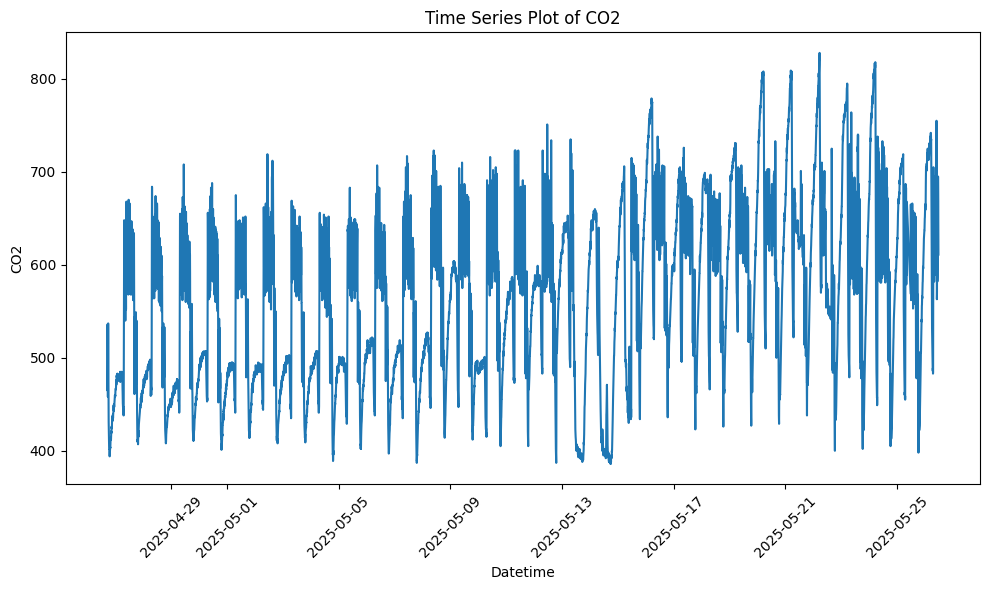

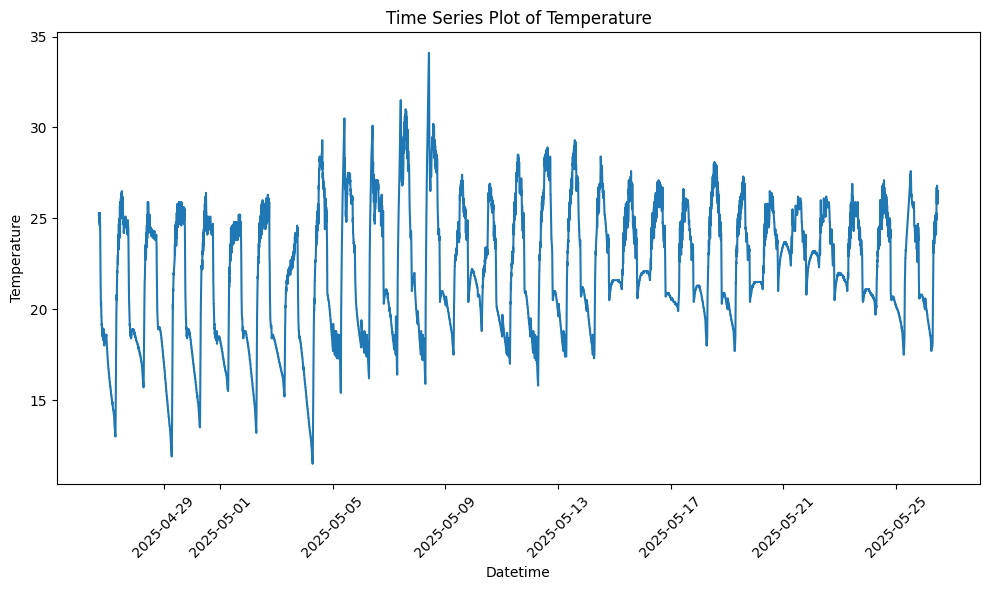

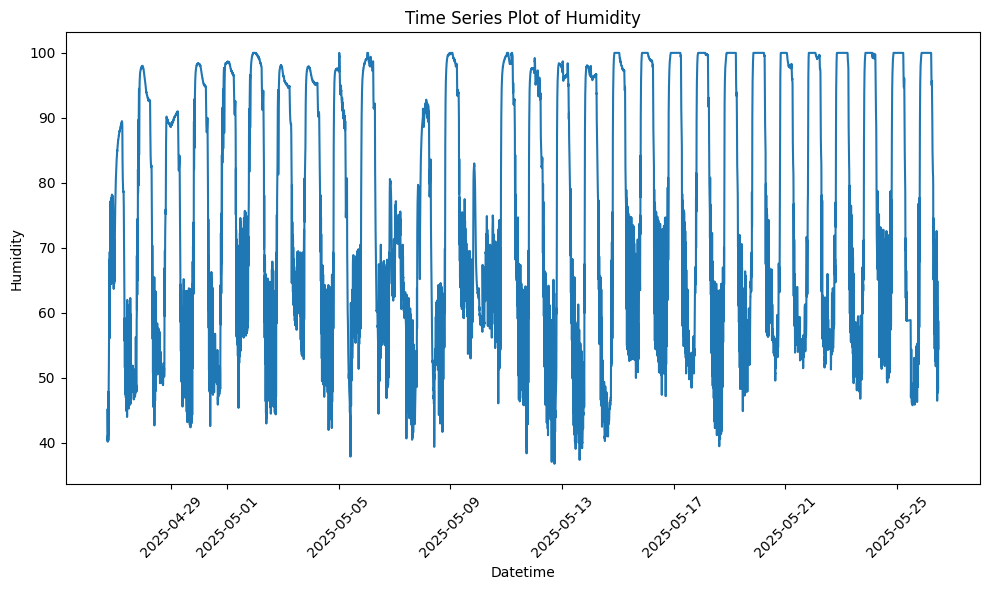

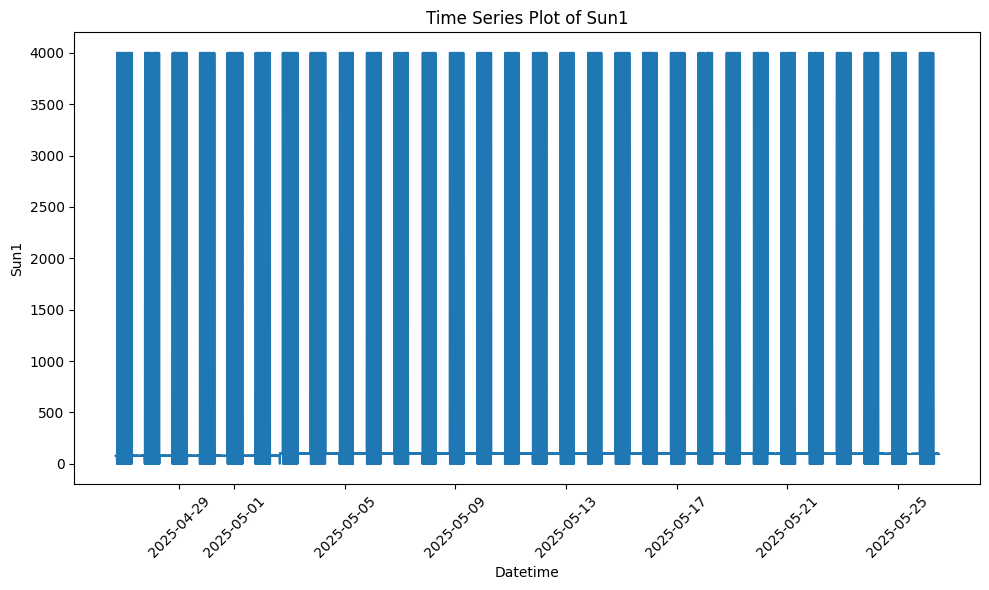

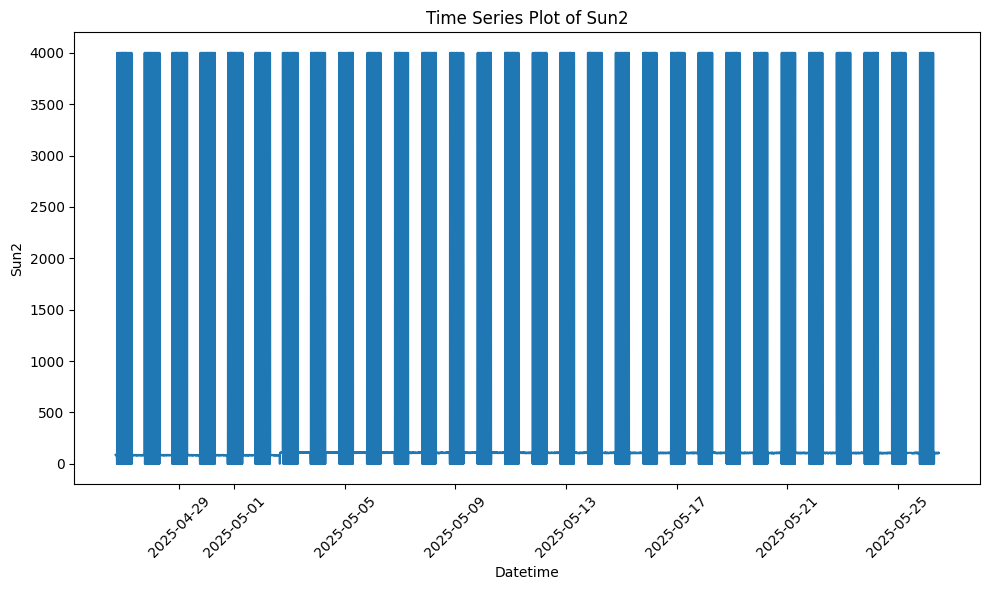

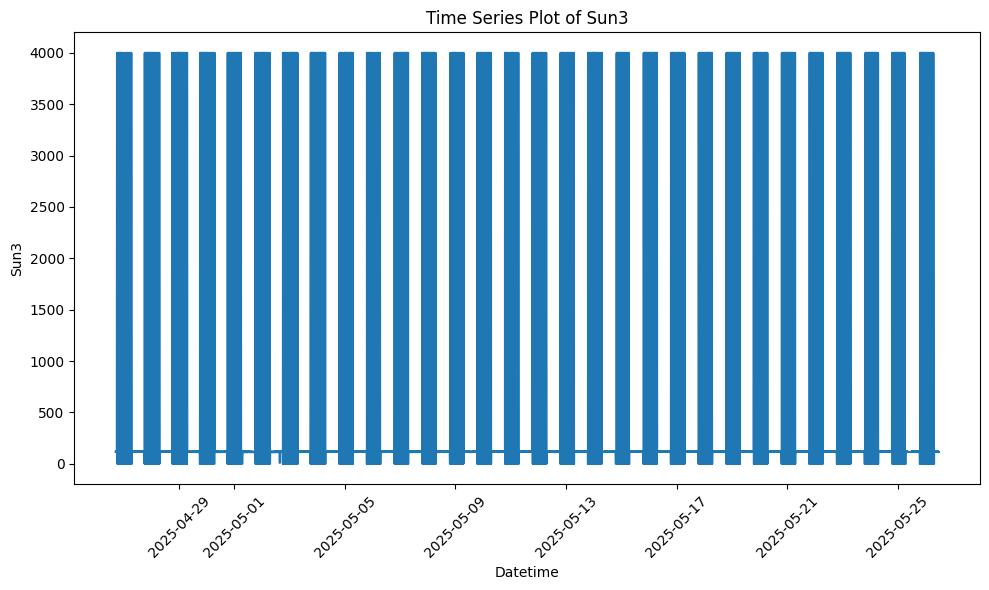

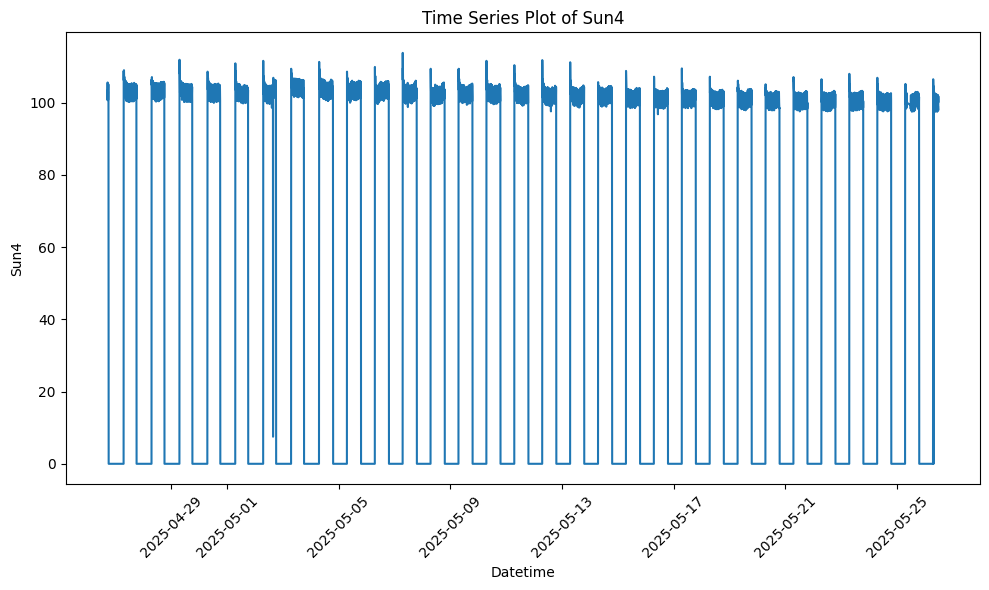

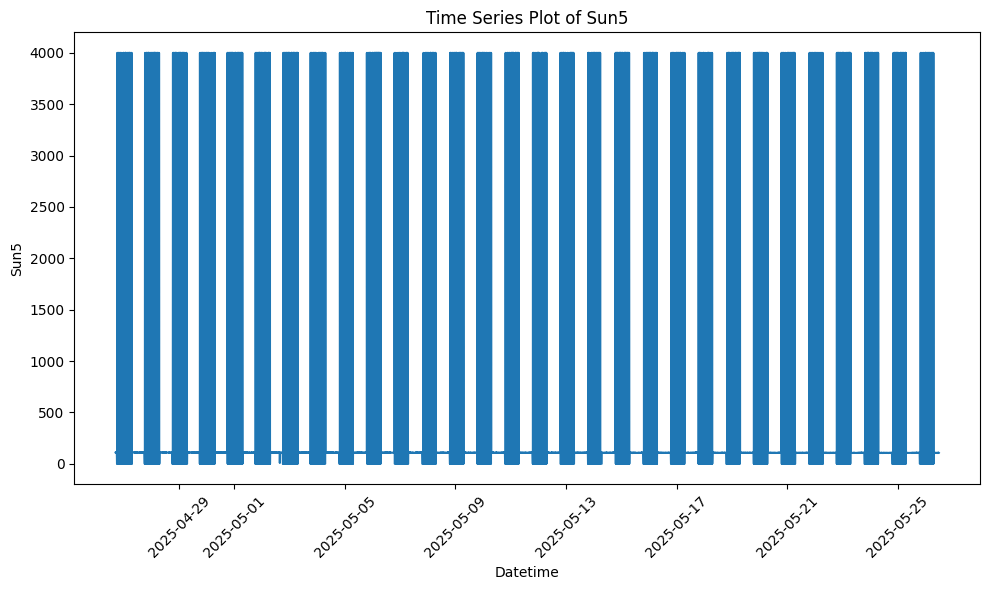

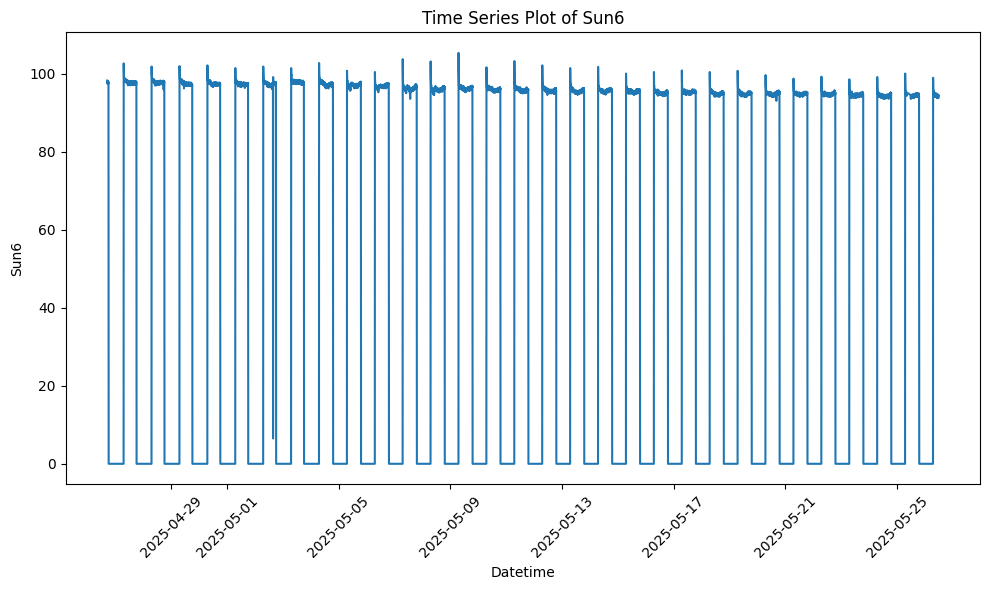

In [72]:
# plot the data each column into a separate plot
for column in df_filtered.columns:
    if column != 'Datetime':
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_filtered, x='Datetime', y=column)
        plt.title(f'Time Series Plot of {column}')
        plt.xlabel('Datetime')
        plt.ylabel(column)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [73]:
len(df_filtered)

8474

In [74]:
# save the filtered DataFrame to a CSV file
df_filtered.to_csv('data-com-latest.csv', index=False)